In [1]:
from matplotlib.patches import Rectangle
import matplotlib as mpl
mpl.use('Agg') # run matplotlib without X server (GUI)
import matplotlib.pyplot as plt
%matplotlib inline

from Dataset import Dataset, saveDataset, loadDataset
from CNN_Model import CNN_Model, loadModel, saveModel
from ECOC_Classifier import ECOC_Classifier
from Stage import Stage
from Staged_Network import Staged_Network, saveStagedModel, loadStagedModel
from Utils import *

from localization_utilities import *
from main import *

from keras.models import Sequential, Graph, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.advanced_activations import PReLU

# Import Selective Search code
selsearch_root = '/home/lifelogging/code/selective_search'
import sys
sys.path.insert(0, selsearch_root)
import sel_search

import os
import logging
import copy
from operator import add
import numpy as np
import scipy
from scipy import ndimage
from scipy import misc
from skimage.transform import resize

logging.basicConfig(level=logging.DEBUG, format='[%(asctime)s] %(message)s', datefmt='%d/%m/%Y %H:%M:%S')

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, CuDNN 3007)
/home/lifelogging/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [40]:
# Path to the produced evaluation measures
path_data = '/media/HDD_2TB/marc/FoodDetection_keras_Data/CAMs_val_ego'

# Load list of classes
path_classes = '/media/HDD_2TB/DATASETS/EgocentricFood_recognition/classes.txt'
classes = []
with open(path_classes, 'r') as list_c:
    for line in list_c:
        line = line.rstrip('\n')
        line = line.rstrip('\r')
        classes.append(line)

In [55]:
nbackup = 900
method = 'GAP'

# Load all the necessary data
prec = np.load(path_data+'/precisions_backup_'+str(nbackup)+'_'+method+'.npy')
rec = np.load(path_data+'/recalls_backup_'+str(nbackup)+'_'+method+'.npy')
acc = np.load(path_data+'/accuracies_backup_'+str(nbackup)+'_'+method+'.npy')
nGT = np.load(path_data+'/num_GT_backup_'+str(nbackup)+'_'+method+'.npy')
nPred = np.load(path_data+'/num_predictions_backup_'+str(nbackup)+'_'+method+'.npy')

prec_c = np.load(path_data+'/precisions_classes_backup_'+str(nbackup)+'_'+method+'.npy')
rec_c = np.load(path_data+'/recalls_classes_backup_'+str(nbackup)+'_'+method+'.npy')
acc_c = np.load(path_data+'/accuracies_classes_backup_'+str(nbackup)+'_'+method+'.npy')
nGT_c = np.load(path_data+'/num_GT_classes_backup_'+str(nbackup)+'_'+method+'.npy')
nPred_c = np.load(path_data+'/num_predictions_classes_backup_'+str(nbackup)+'_'+method+'.npy')


# [per_heat, size_res, box_exp, iou, n_bb] for each test
params = np.load(path_data+'/params_cross_val_backup_'+str(nbackup)+'_'+method+'.npy')

# [predicted_bboxes, predicted_Y, predicted_scores, GT_bboxes, GT_Y] for each image
reports = np.load(path_data+'/reports_backup_'+str(nbackup)+'_'+method+'.npy')

## Choose best combination of parameters

In [56]:
# Get test settings with best average accuracy when comparing all IoU thresholds
len_sequence_IoU = 6
valid = acc.shape[0]-acc.shape[0]%len_sequence_IoU


acc__ = np.reshape(acc[:valid], (valid/6,6))
best_ind = np.argmax(np.mean(acc__, axis=1))*6
print acc[best_ind:best_ind+len_sequence_IoU]
print best_ind

# Get test settings with best absolute recall
best_ind_ = np.argmax(rec)
print rec[best_ind_]
print best_ind_

# Get test settings with best average recall when comparing all IoU thresholds
len_sequence_IoU = 6
rec__ = np.reshape(rec[:valid], (valid/6,6))
best_ind_ = np.argmax(np.mean(rec__, axis=1))*6
print rec[best_ind_:best_ind_+len_sequence_IoU]
print best_ind_

print "Best test position: " + str(best_ind)
print "Best accuracy: " +str(acc[best_ind])
print "Best precision: " +str(prec[best_ind])
print "Best recall: " +str(rec[best_ind])
print "Best params:" 
print "[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]"
print params[best_ind]

best_params = params[best_ind]
best_reports = reports[best_ind]

[ 0.03632075  0.01524954  0.00733608  0.00182399  0.          0.        ]
390
0.0433574207893
360
[ 0.04335742  0.01834352  0.00889383  0.00222346  0.          0.        ]
360
Best test position: 390
Best accuracy: 0.036320754717
Best precision: 0.193467336683
Best recall: 0.0428015564202
Best params:
[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]
[  6.00000000e-01   2.00000000e-02   2.00000000e-01   5.00000000e-01
   9.99900000e+03]


## Generate Precision-Recall curve

In [7]:
path_imgs = '/media/HDD_2TB/DATASETS/EgocentricFood'
test_list = 'val_list.txt'

# CAMs path
maps_dir = '/media/HDD_2TB/marc/FoodDetection_keras_Data/CAMs_val_ego'

# Recognition model
model_path_rec = '/media/HDD_2TB/CNN_MODELS/GoogleNet_EgocentricFood/finetuning_Food101_NoFood'
iter_rec = 9000
n_classes = 10

In [8]:
# Load dataset for pre-processing test images
ds = loadDataset('Datasets/Dataset_FoodVsNoFood.pkl')
# Load UEC detection test set
[ds, samples_detection] = loadUECDetectionTest(ds, path_imgs, test_list)
# Load predictions from GAP model
predictions = np.load(maps_dir+'/predictions.npy')

In [37]:
# Load recognition model
#net = None # not applying recognition right now
net = loadModel(model_path_rec, iter_rec)

#### Test with best params and increasing the number of picked samples at each iteration for computing the curve

In [38]:
parameters = dict()
parameters['percentage_heat'] = best_params[0]
parameters['size_restriction'] = best_params[1]+0.001
parameters['box_expansion'] = best_params[2]
parameters['IoU'] = best_params[3]
iou_values = np.arange(0.5,1.01,0.1)
iou_values = [0.5]
#n_bboxes = [1,2,20]
n_bboxes = [9999]

# Iterate picking one more samples each iteration and use the pre-calculated reports
list_measures = []
list_measures_classes = []
for iou in iou_values:
    for nbb in n_bboxes:
        parameters['n_bboxes'] = nbb
        parameters['IoU'] = iou
        print 'parameters = '+str(parameters)
        [general_measures, class_measures, report_classes] = computePrecisionRecall(net, n_classes, ds, maps_dir, \
                                                                         samples_detection, predictions, \
                                                                         parameters, detect_type='GAP')#, report_all=best_reports)
        print general_measures
        print
        list_measures.append(general_measures)
        #[prec_classes, rec_classes, acc_classes, total_GT_classes, total_pred_classes] = class_measures
        list_measures_classes.append(class_measures)

parameters = {'n_bboxes': 9999, 'box_expansion': 0.20000000000000001, 'IoU': 0.5, 'size_restriction': 0.060999999999999999, 'percentage_heat': 0.20000000000000001}
[0.08278145695364239, 0.013896609227348526, 0.012042389210019268, 1799, 302]



## Use Selective Search for generating candidates

In [9]:
# Path to the produced evaluation measures
selpath_data = '/media/HDD_2TB/marc/FoodDetection_keras_Data/SelSearch_val_ego'

# Load all the necessary data
detect_type = 'SelSearch'

selprec = np.load(selpath_data+'/precisions_'+detect_type+'.npy')
selrec = np.load(selpath_data+'/recalls_'+detect_type+'.npy')
selacc = np.load(selpath_data+'/accuracies_'+detect_type+'.npy')
selnGT = np.load(selpath_data+'/num_GT_'+detect_type+'.npy')
selnPred = np.load(selpath_data+'/num_predictions_'+detect_type+'.npy')

selprec_c = np.load(selpath_data+'/precisions_classes_'+detect_type+'.npy')
selrec_c = np.load(selpath_data+'/recalls_classes_'+detect_type+'.npy')
selacc_c = np.load(selpath_data+'/accuracies_classes_'+detect_type+'.npy')
selnGT_c = np.load(selpath_data+'/num_GT_classes_'+detect_type+'.npy')
selnPred_c = np.load(selpath_data+'/num_predictions_classes_'+detect_type+'.npy')


# [per_heat, size_res, box_exp, iou, n_bb] for each test
selparams = np.load(selpath_data+'/params_cross_val_'+detect_type+'.npy')

# [predicted_bboxes, predicted_Y, predicted_scores, GT_bboxes, GT_Y] for each image
selreports = np.load(selpath_data+'/reports_'+detect_type+'.npy') 

In [10]:
print selnPred
selbest_ind = np.argmax(selacc)
print "Best test position: " + str(selbest_ind)
print "Best accuracy: " +str(selacc[selbest_ind])
print "Best precision: " +str(selprec[selbest_ind])
print "Best recall: " +str(selrec[selbest_ind])
print "Best params:" 
print "[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]"
print selparams[selbest_ind]

selbest_params = selparams[selbest_ind]
selbest_reports = selreports[selbest_ind]

[2710278 2710278 2710278 2710278 2710278 2710278]
Best test position: 0
Best accuracy: 0.000512416036076
Best precision: 0.000512493552322
Best recall: 0.772095608671
Best params:
[percentage_heat, size_restriction, box_expansion, IoU, n_bboxes]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   5.00000000e-01
   9.99900000e+03]


In [29]:
parameters = dict()
parameters['percentage_heat'] = 0
parameters['size_restriction'] = 0
parameters['box_expansion'] = 0
parameters['IoU'] = selbest_params[3]
iou_values = np.arange(0.5, 1.01, 0.1)
#n_bboxes = np.arange(0,1000,1)
n_bboxes = [5]

# Iterate picking one more samples each iteration and use the pre-calculated reports
sellist_measures = []
for iou in iou_values:
    for nbb in n_bboxes:
        parameters['n_bboxes'] = nbb
        parameters['IoU'] = iou
        print 'parameters = '+str(parameters)
        [selgeneral_measures, selclass_measures, selreport] = computePrecisionRecall(net, n_classes, ds, selpath_data, \
                                                                         samples_detection, [], \
                                                                         parameters, detect_type='SelSearch')
                                                                         #, report_all=best_reports)
        print selgeneral_measures
        print 
        sellist_measures.append(selgeneral_measures)
        #[selprec, selrec, selacc, seltotal_GT, seltotal_pred] = selgeneral_measures
        #[selprec_classes, selrec_classes, selacc_classes, seltotal_GT_classes, seltotal_pred_classes] = selclass_measures

parameters = {'n_bboxes': 5, 'box_expansion': 0, 'IoU': 0.5, 'size_restriction': 0, 'percentage_heat': 0}
[0.13335098986956234, 0.5425646551724138, 0.11987381703470032, 3712, 15103]

parameters = {'n_bboxes': 5, 'box_expansion': 0, 'IoU': 0.59999999999999998, 'size_restriction': 0, 'percentage_heat': 0}
[0.07826259683506588, 0.31842672413793105, 0.06703340327794476, 3712, 15103]

parameters = {'n_bboxes': 5, 'box_expansion': 0, 'IoU': 0.69999999999999996, 'size_restriction': 0, 'percentage_heat': 0}
[0.040389326623849565, 0.16433189655172414, 0.03350727822026916, 3712, 15103]

parameters = {'n_bboxes': 5, 'box_expansion': 0, 'IoU': 0.79999999999999993, 'size_restriction': 0, 'percentage_heat': 0}
[0.02112163146394756, 0.0859375, 0.0172469723183391, 3712, 15103]

parameters = {'n_bboxes': 5, 'box_expansion': 0, 'IoU': 0.89999999999999991, 'size_restriction': 0, 'percentage_heat': 0}
[0.006223929020724359, 0.025323275862068964, 0.005021099300251055, 3712, 15103]

parameters = {'n_bboxes'

### Plot some examples

In [ ]:
#id_img = 2376
#windows = sel_search.get_windows([samples_detection['list_imgs'][id_img]])
#windows = np.load(selpath_data +'/'+ samples_detection['all_ids'][id_img] +'_windows.npy')

[[[0, 0, 2314, 1200]] [] [0.38387754304269289]
 [[780.9175, 6.7371, 1177.0928, 1185.7165], [1363.2474, 288.3557, 1969.4433, 1185.7165], [2141.2784, 431.5515, 2308.3402, 1114.1186]]
 [1, 4, 4]]


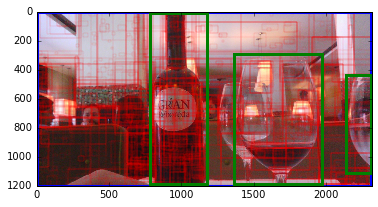

In [35]:
id_img = 191

im = misc.imread(samples_detection['list_imgs'][id_img])
ax = plt.subplot(1,1,1)
plt.imshow(im)

# Selective Search result
#### BEWERE! we are using stored reports instead of the last output
#'''
selreport = selreports[selbest_ind]
for box in selreport[id_img][0]:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='red', linewidth=.1))
#'''
# FoodVsNoFood GoogleNet-GAP result
#### BEWERE! we are using stored reports instead of the last output
report = reports[best_ind]
print report[id_img]
for box in report[id_img][0]:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='blue', linewidth=3.0))
    
# Ground Truth
for box in report[id_img][3]:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='green', linewidth=3.0))

/media/HDD_2TB/DATASETS/EgocentricFood/1/1350.jpg
[[], [], [], [[1000.2237, 10.6732, 1401.9392, 1133.6505], [607.6381, 156.7515, 866.3186, 1112.3474], [17.2381, 171.968, 458.5165, 1437.9804], [586.3351, 1115.3907, 1462.8052, 1462.3268]], [1, 1, 4, 7]]


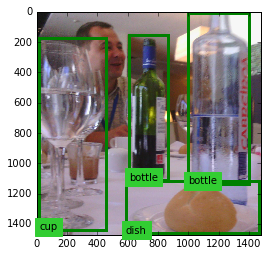

In [43]:
id_img = 189 # ~good

id_img = 199

print samples_detection['list_imgs'][id_img]
im = misc.imread(samples_detection['list_imgs'][id_img])
ax = plt.subplot(1,1,1)
plt.imshow(im)

# Selective Search result
#### BEWERE! we are using stored reports instead of the last output
#selreport = selreports[selbest_ind]
#for box in selreport[id_img][0]:
#    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3],-box[1] facecolor="none", edgecolor='red'))

# FoodVsNoFood GoogleNet-GAP result
print report_classes[id_img]
for box, y, prob in zip(report_classes[id_img][0], report_classes[id_img][1], report_classes[id_img][2]):
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='blue', linewidth=3.0))
    ax.text(box[0]+10, box[1]+25, classes[y] + ' (' + str(prob)[:5] + ')', backgroundcolor='cornflowerblue')
    
# Ground Truth
for box, y in zip(report_classes[id_img][3], report_classes[id_img][4]):
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='green', linewidth=3.0))
    ax.text(box[0], box[3], classes[y], backgroundcolor='limegreen')

98
/media/HDD_2TB/DATASETS/EgocentricFood/1/0670.jpg
[[], [], [], [[2054.5, 1174.5, 2282.5, 1514.5], [2066.5, 1482.5, 2478.5, 1938.5]], [1, 8]]
99
/media/HDD_2TB/DATASETS/EgocentricFood/3/0671.jpg
[[], [], [], [[14.1705, 1210.2693, 900.8017, 1835.2076], [189.9344, 85.3804, 643.0147, 483.7785]], [3, 3]]
101
/media/HDD_2TB/DATASETS/EgocentricFood/1/0696.jpg
[[], [], [], [[1871.8911, 1032.7791, 2123.9672, 1410.8932], [1915.7304, 1345.1342, 2315.7643, 1838.3266]], [1, 8]]
103
/media/HDD_2TB/DATASETS/EgocentricFood/1/0707.jpg
[[], [], [], [[444.3293, 1382.1557, 817.1976, 2138.1078], [505.6228, 2133.0, 975.5389, 2516.0838]], [1, 8]]
106
/media/HDD_2TB/DATASETS/EgocentricFood/9/0723.jpg
[[], [], [], [[12.6906, 1155.1257, 395.8244, 1479.0479], [611.7725, 1231.7525, 1071.5329, 1548.7086]], [9, 9]]
107
/media/HDD_2TB/DATASETS/EgocentricFood/3/0739.jpg
[[[0.69999999999998863, 0, 1943, 2591]], [7], [0.99832922], [[651.7335, 1487.9251, 1319.1347, 1922.512], [444.7874, 970.5599, 977.6737, 1358.5838]

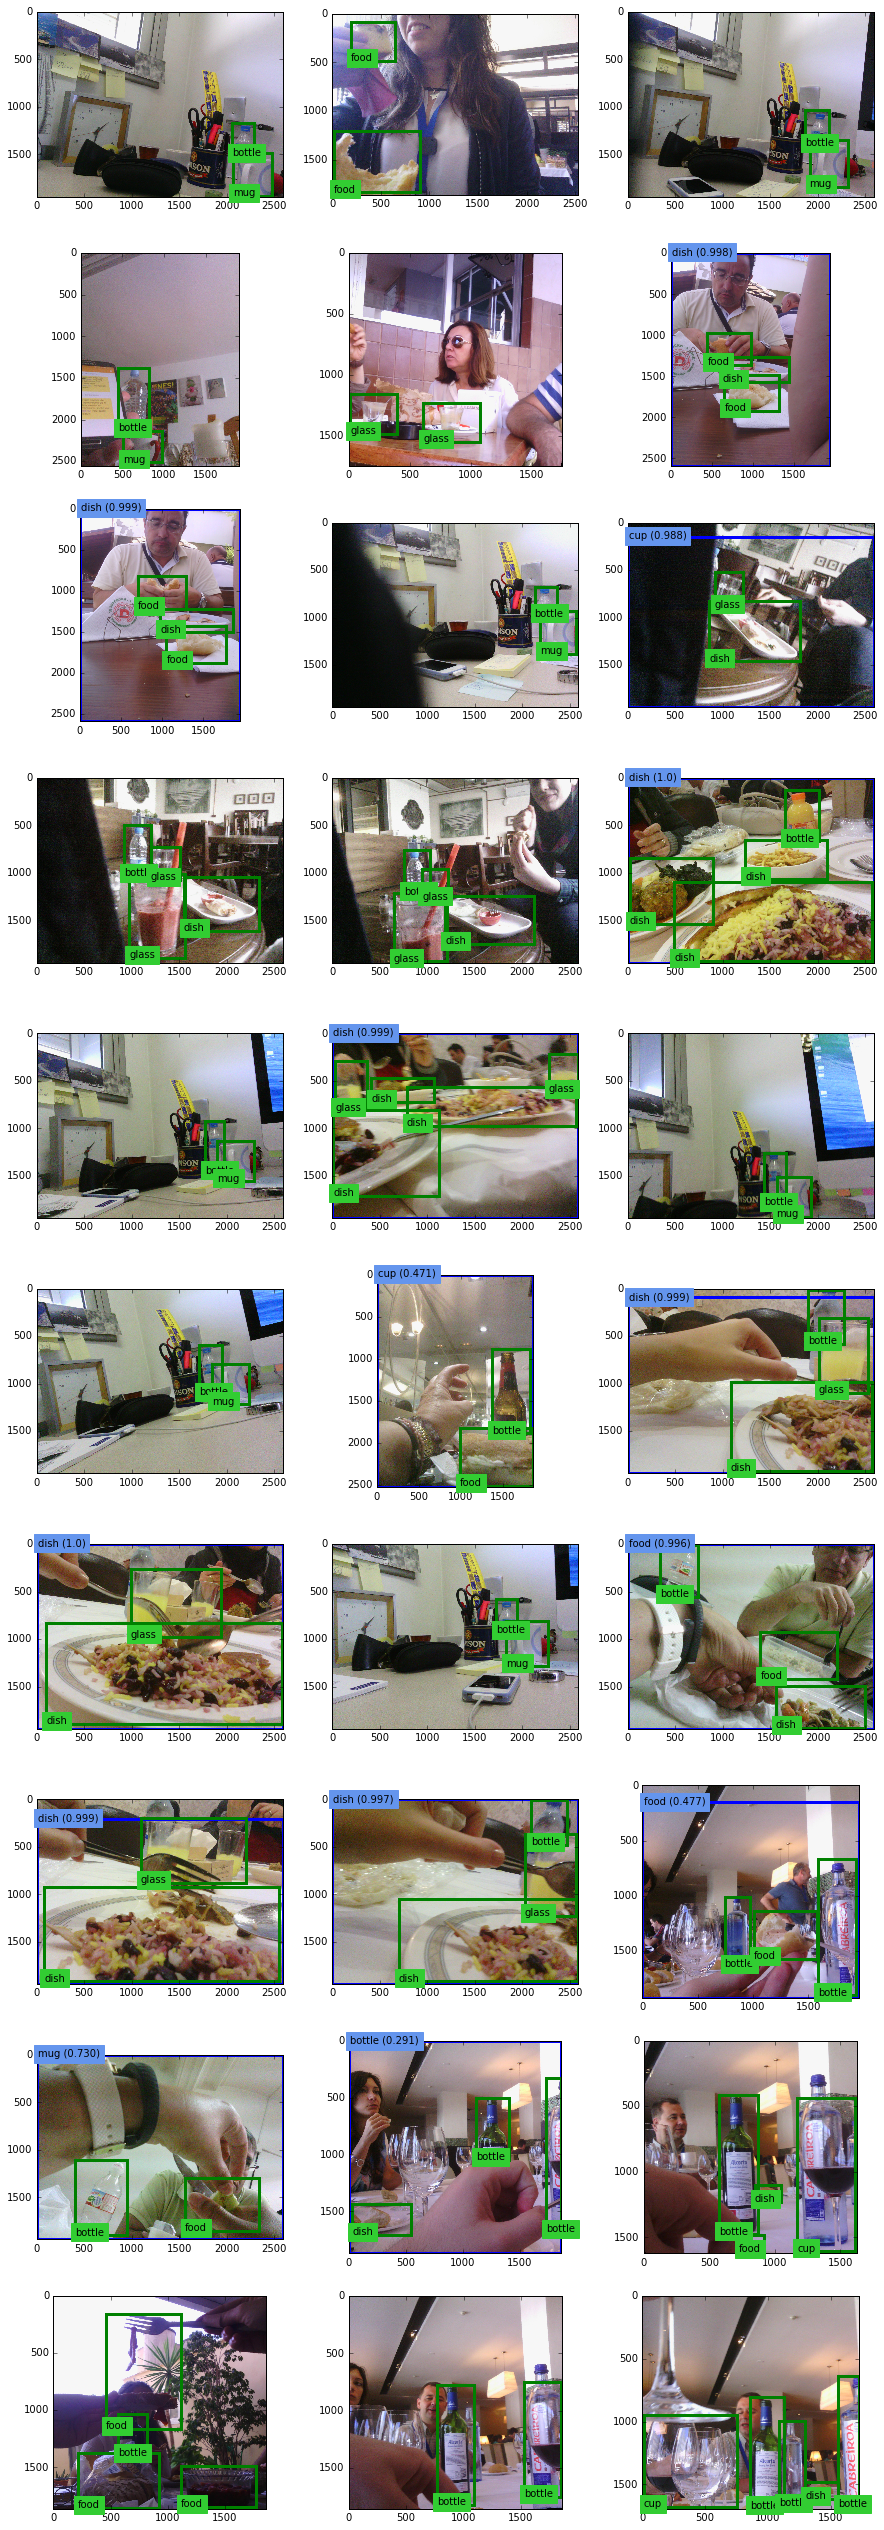

In [46]:
id_img = 98
found = 0

f = plt.figure(1)
f.set_size_inches(15, 15*3)
while(found < 30):
    if(len(report_classes[id_img][4]) > 1 or len(report_classes[id_img][1]) > 1):
        found += 1
        print id_img
        print samples_detection['list_imgs'][id_img]
        im = misc.imread(samples_detection['list_imgs'][id_img])
        ax = plt.subplot(10,3,found)
        plt.imshow(im)

        # Selective Search result
        #### BEWERE! we are using stored reports instead of the last output
        #selreport = selreports[selbest_ind]
        #for box in selreport[id_img][0]:
        #    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3],-box[1] facecolor="none", edgecolor='red'))

        # FoodVsNoFood GoogleNet-GAP result
        print report_classes[id_img]
        for box, y, prob in zip(report_classes[id_img][0], report_classes[id_img][1], report_classes[id_img][2]):
            ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='blue', linewidth=3.0))
            ax.text(box[0]+10, box[1]+25, classes[y] + ' (' + str(prob)[:5] + ')', backgroundcolor='cornflowerblue')

        # Ground Truth
        for box, y in zip(report_classes[id_img][3], report_classes[id_img][4]):
            ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor="none", edgecolor='green', linewidth=3.0))
            ax.text(box[0], box[3], classes[y], backgroundcolor='limegreen')
        
    id_img += 1

#### Plot Recall/Precision/Accuracy vs IoU

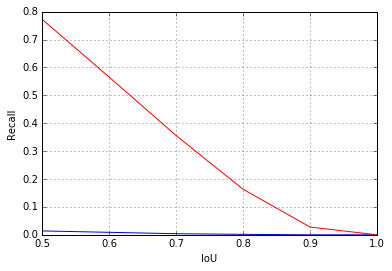

In [47]:
sequence = [best_ind, best_ind+6]
selsequence = [selbest_ind, selbest_ind+6]

# Plot data
plt.plot(rec[sequence[0]:sequence[1]], color='blue')
plt.plot(selrec[selsequence[0]:selsequence[1]], color='red')
plt.grid()

# Set Y labels
plt.ylabel('Recall')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')

(0, 0.1)

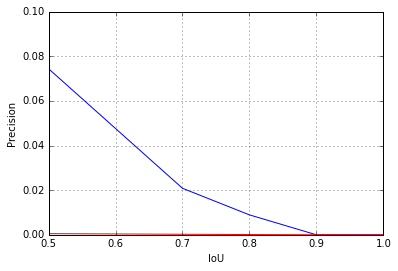

In [50]:
# Plot data
plt.plot(prec[sequence[0]:sequence[1]], color='blue')
plt.plot(selprec[selsequence[0]:selsequence[1]], color='red')
plt.grid()

# Set Y labels
plt.ylabel('Precision')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')
plt.ylim([0,0.1])

(0, 0.03)

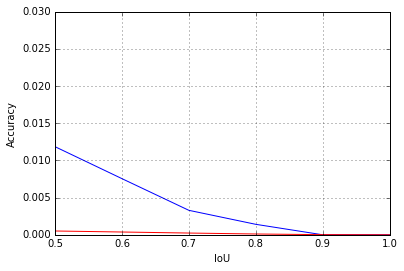

In [52]:
# Plot data
plt.plot(acc[sequence[0]:sequence[1]], color='blue')
plt.plot(selacc[selsequence[0]:selsequence[1]], color='red')
plt.grid()

# Set Y labels
plt.ylabel('Accuracy')

# Set X labels and ticks
labels = [str(params[i][3]) for i in range(sequence[0], sequence[1])]
plt.xticks(np.arange(6), tuple(labels))
plt.xlabel('IoU')
plt.ylim([0, 0.03])

## Detection methods time comparison (including image loading): SelSearch 0.8s per image, GAP 0.06s per image

In [54]:
print np.mean(list_measures_classes[-1][0][1:]) # precision
print np.mean(list_measures_classes[-1][1][1:]) # recall
print np.mean(list_measures_classes[-1][2][1:]) # accuracy

0.138381834215
0.0244575098776
0.0199351774498
